## Load dependencies and object

In [1]:
# The purpose of this notebook is to visually show that the new features added to athena, 
# namely the sub set graph building functionality, works appropriately. 

# Note: this notebook should be run in an environment where the publicly available athena version of the package is not installed. 
# Needles to say all of the other dependencies described in the requirements.txt and dev_requirements.txt should be available.

import os
import sys
import matplotlib.pyplot as plt

# Add path to the ATHENA beta repository
module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Import Local package
import athena as ath

# Load data
so = ath.dataset.imc()

# Define sample
spl = 'slide_49_By2x5'

# Extract centroids
ath.pp.extract_centroids(so, spl, mask_key='cellmasks')

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


## Construct full graphs

In [3]:
# import default graph builder parameters and build graphs using ALL NODES
from athena.utils.default_configs import get_default_config
import copy as cp

# kNN graph
config = get_default_config(
        builder_type='knn',
        build_concept_graph=False,
        build_and_attribute=False
        )
config['builder_params']['n_neighbors'] = 6 # set parameter k
ath.graph.build_graph(so, spl, config=config)

In [6]:
# radius graph
config = get_default_config(
        builder_type='radius',
        build_concept_graph=False,
        build_and_attribute=False
        )
config['builder_params']['radius'] = 20 # set radius
ath.graph.build_graph(so, spl, config=config)

# contact graph - this takes some time
config = get_default_config(
        builder_type='contact',
        build_concept_graph=False,
        build_and_attribute=False
        )
ath.graph.build_graph(so, spl, config=config)

# the results are saved back into `.G`:
so.G[spl]

100%|██████████| 1541/1541 [00:18<00:00, 83.82it/s]


{'contact': <networkx.classes.graph.Graph at 0x7fa1c00a6880>,
 'knn': <networkx.classes.graph.Graph at 0x7f9f17f73940>,
 'radius': <networkx.classes.graph.Graph at 0x7f9f28c28af0>}

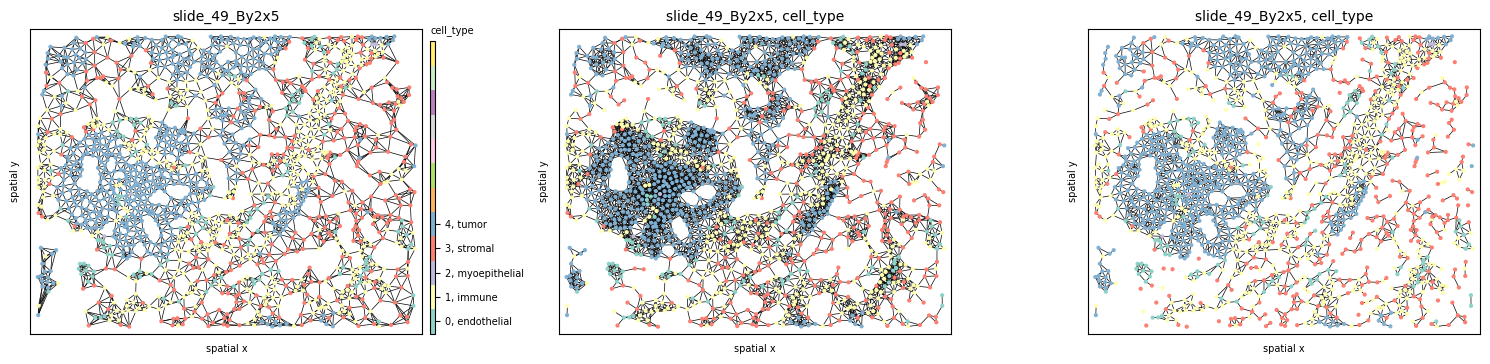

In [7]:
# Viuslaize full-graphs
fig, axs = plt.subplots(1, 3, figsize=(15, 6), dpi=100)
ath.pl.spatial(so, spl, 'cell_type', edges=True, graph_key='knn', ax=axs.flat[0], cbar=True)
ath.pl.spatial(so, spl, 'cell_type', edges=True, graph_key='radius', ax=axs.flat[1], cbar=False)
ath.pl.spatial(so, spl, 'cell_type', edges=True, graph_key='contact', ax=axs.flat[2], cbar=False)

## Construct subset (concept) graphs

In [8]:
# Decide on subset
labels = ['endothelial', 'tumor']
filter_col = 'cell_type'

# Build subset graphs
# kNN graph
config = get_default_config(
        builder_type='knn',
        build_concept_graph=True,
        build_and_attribute=False)
config['builder_params']['n_neighbors'] = 6 # set parameter k
config['concept_params']['filter_col'] = filter_col
config['concept_params']['include_labels'] = labels
ath.graph.build_graph(so, spl, config=config, key_added="knn_concept")

In [9]:

# radius graph
config = get_default_config(
        builder_type='radius',
        build_concept_graph=True,
        build_and_attribute=False)
config['builder_params']['radius'] = 20 # set radius
config['concept_params']['filter_col'] = filter_col
config['concept_params']['include_labels'] = labels
ath.graph.build_graph(so, spl, config=config, key_added="radius_concept")


In [10]:

# contact graph - this takes some time
config = get_default_config(
        builder_type='contact',
        build_concept_graph=True,
        build_and_attribute=False)
config['concept_params']['filter_col'] = filter_col
config['concept_params']['include_labels'] = labels
ath.graph.build_graph(so, spl, config=config, key_added="contact_concept")

# the results are saved back into `.G`:
so.G[spl]

100%|██████████| 714/714 [00:08<00:00, 88.80it/s]


{'contact': <networkx.classes.graph.Graph at 0x7fa1c00a6880>,
 'knn': <networkx.classes.graph.Graph at 0x7f9f17f73940>,
 'radius': <networkx.classes.graph.Graph at 0x7f9f28c28af0>,
 'knn_concept': <networkx.classes.graph.Graph at 0x7fa099210970>,
 'radius_concept': <networkx.classes.graph.Graph at 0x7fa098c91d90>,
 'contact_concept': <networkx.classes.graph.Graph at 0x7fa0992342b0>}

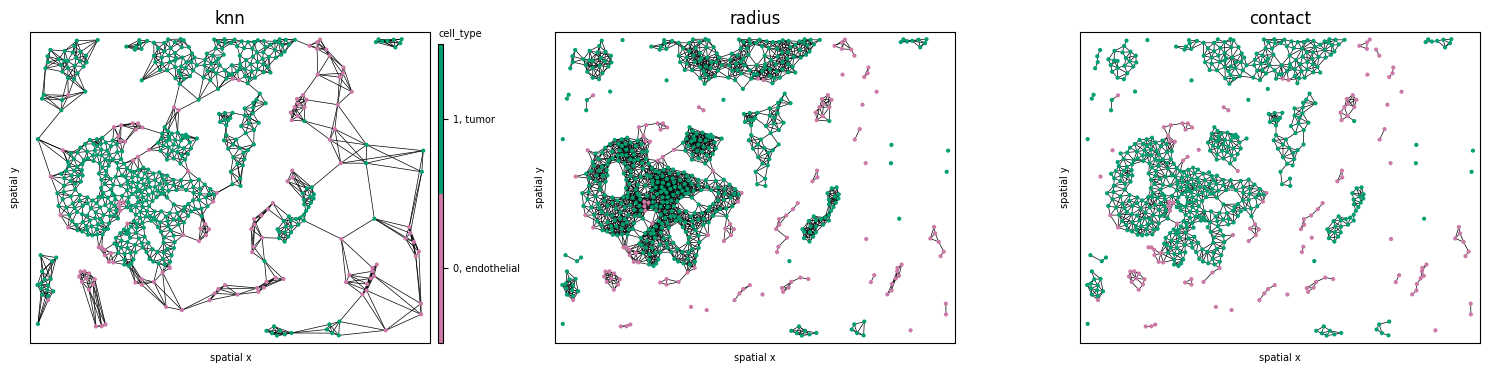

In [12]:
# Viuslaize full-graphs
fig, axs = plt.subplots(1, 3, figsize=(15, 6), dpi=100)

colors = {
    'tumor':'#009E73', 
    'endothelial':'#CC79A7', 
}
from matplotlib.colors import ListedColormap
def get_colors_map(list_of_types):
    l = []
    for type in list_of_types:
        l.append(colors[type])
    return ListedColormap(l)

for i, gtype in enumerate(["knn", "radius", "contact"]):
    cbar = True if gtype =="knn" else False
    ath.pl.spatial(
        so, spl, 'cell_type', 
        edges=True, 
        graph_key=f'{gtype}_concept', 
        ax=axs.flat[i], 
        cbar=cbar,
        cmap=get_colors_map(config["concept_params"]["include_labels"]),
        filter_col=config["concept_params"]["filter_col"], 
        labels=config["concept_params"]["include_labels"]
    )
    axs.flat[i].set_title(f"{gtype}")